In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
import time
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

# Raw Data Overview #

Only Quality Cuts that are being made here are just the quality cuts associated with the ZTF DR2 Paper:

https://www.aanda.org/articles/aa/pdf/2025/02/aa50388-24.pdf

lccoverage_flag passes the good sampling cut (bool, Table 1)

fitquality_flag passes all other Basic cuts (bool, Table 1)

<div style="text-align: left; display: block !important;">

**Table 1. ZTF cosmology science working group DR2 sample statistics.**

| Cuts | n targets | Removed | % Removed |
|------|-----------|---------|-----------|
| Master list | 3795 | — | — |
| + ZTF light curve | 3778 | 17 | 0.4 |
| + a spectrum | 3668 | 110 | 2.9 |
| + confirmed “Ia” | **3628** | 40 | 1.1 |
| **Basic cuts** ||||
| Good light curve sampling | 2960 | 668 | 18.4 |
| \( x_1 \in [-3, +3] \) | 2899 | 61 | 2.1 |
| \( c \in [-0.2, 0.8] \) | 2861 | 38 | 1.4 |
| \( \sigma_{t_0} \le 1 \) | 2836 | 25 | 0.9 |
| \( \sigma_{x_1} \le 1 \) | 2822 | 14 | 0.5 |
| \( \sigma_c \le 0.1 \) | 2809 | 13 | 0.4 |
| `fitprob ≥ 10^{-7}` | **2667** | 142 | 5.1 |
</div>

776 SNe before paper-based quality cuts.
579 SNe after paper-based quality cuts.


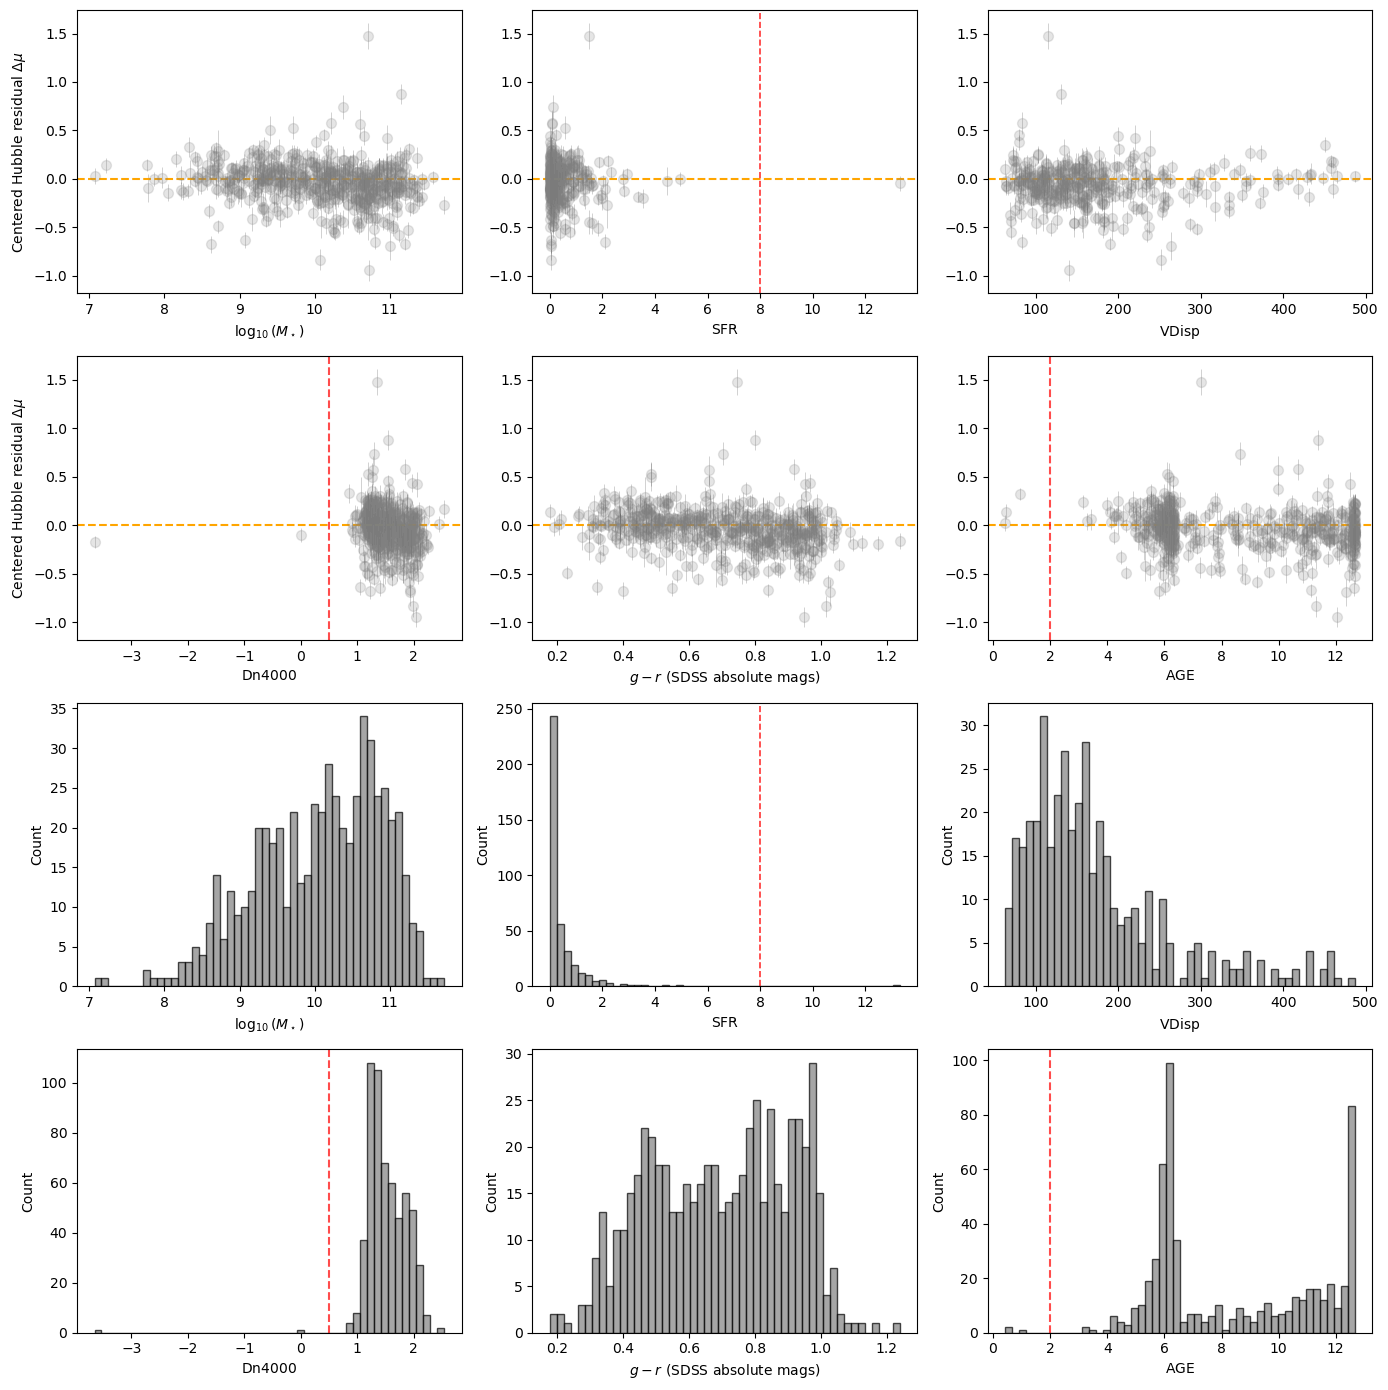

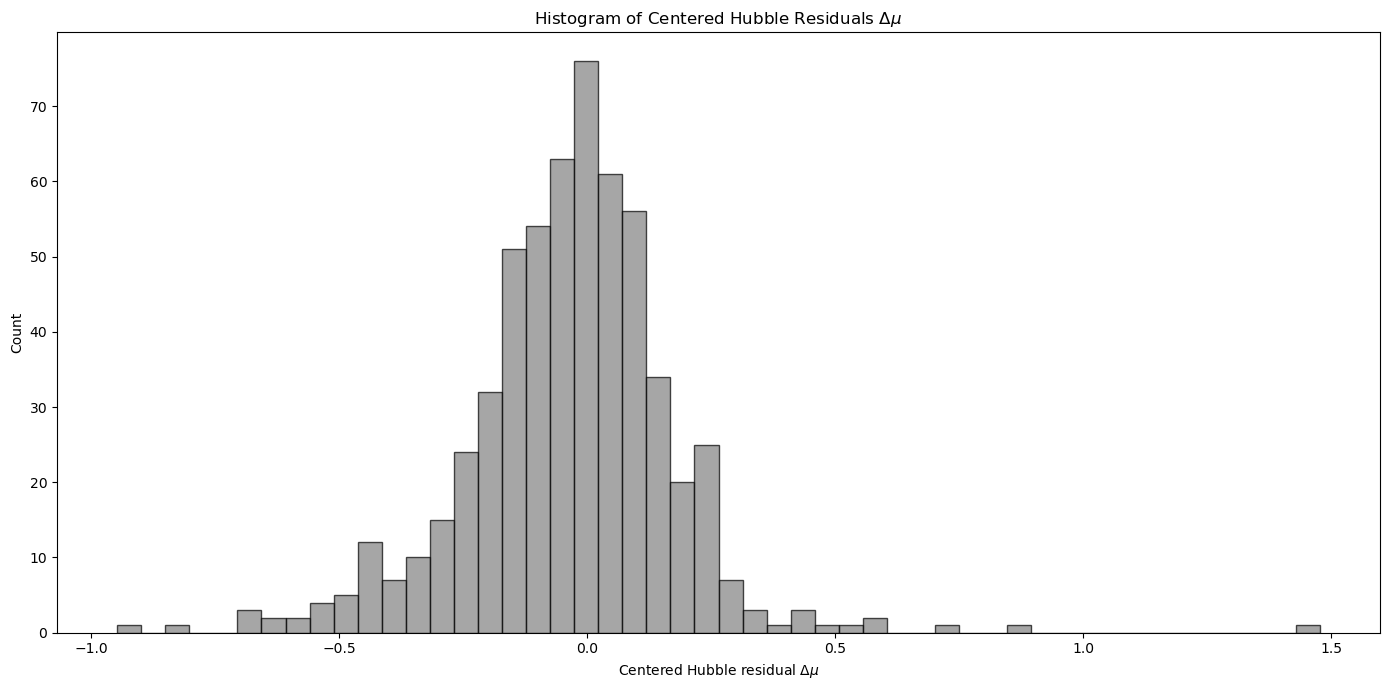

In [2]:
df = pd.read_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv")

# -----------------------------------------------------
# DATA FILTER - Paper lccoverage_flag and fitquality_flag
# -------------------------------------------------------
print(len(df), "SNe before paper-based quality cuts.")
df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]
print(len(df), "SNe after paper-based quality cuts.")

# --------------------------------------
# Create g - r host-galaxy color
# --------------------------------------
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# Read the Error Collumn for the distance modulus measurements.
yerr_all = df["sigma_mu_meas"]

# --------------------------------------
# Set up 4x3 grid (Top 2 rows: scatter, Bottom 2 rows: histograms)
# --------------------------------------
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
axes = axes.flatten()

# The first 6 panels are the scatter plots (same as before)
scatter_axes = axes[:6]

# The next 6 panels are histograms of the x-parameters
hist_axes = axes[6:]

point_kwargs = dict(alpha=0.2, s=50, color="grey", zorder=3)

# Helper funciton that plots the scatter and error bars. 
# ax - matplotlib axis where the plots will be drawn. 
# mask - the mask that selects which rows to use. 
# xcol - name of the df collumn to put on the x axis. Note residuals are always on the y-axis here. 
def scatter_with_errors(ax, mask, xcol):
    x = df.loc[mask, xcol].values
    y = df.loc[mask, "residual_centered"].values
    yerr = yerr_all.loc[mask].values

    # points
    ax.scatter(x, y, **point_kwargs)

    # error bars
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none",               # no markers
        ecolor="black",
        elinewidth=0.5,
        alpha=0.25,
        zorder=2,
    )

    # Also plots a nice horizontal line to denote where the center is. 
    ax.axhline(0, linestyle="--", color="orange")
    return x, y

# Helper function for histogram panels
# ax - matplotlib axis where the histogram will be drawn.
# mask - the mask that selects which rows to use (match scatter panel mask)
# xcol - name of the df column to histogram
def hist_x(ax, mask, xcol, bins=50):
    x = df.loc[mask, xcol].values
    x = x[np.isfinite(x)]
    ax.hist(x, bins=bins, alpha=0.7, edgecolor="black", color="grey")
    ax.set_ylabel("Count")
    return x


# --------------------------------------
# 1) LOGMSTAR
# --------------------------------------

ax = scatter_axes[0]

# Note the following is done as kind of an "in place" filter. 
# there are not actual infinite values of logmstar, but because we
# sometimes need to use a mask in order to 
mask_logm = np.isfinite(df["LOGMSTAR"]) 

# Use the helper function
x, y = scatter_with_errors(ax, mask_logm, "LOGMSTAR")

# Axis labels
ax.set_xlabel(r"$\log_{10}(M_\star)$")
ax.set_ylabel(r"Centered Hubble residual $\Delta \mu$")

# Histogram panel for LOGMSTAR
axh = hist_axes[0]
hist_x(axh, mask_logm, "LOGMSTAR")
axh.set_xlabel(r"$\log_{10}(M_\star)$")


# --------------------------------------
# 2) SFR (SFR != 0)
# --------------------------------------
ax = scatter_axes[1]
mask_sfr = (df["SFR"] != 0) & np.isfinite(df["SFR"])
scatter_with_errors(ax, mask_sfr, "SFR")

# ---- vertical cut line at SFR = 8 ----
ax.axvline(
    8,
    color="red",
    linestyle="--",
    linewidth=1.2,
    alpha=0.8,
)

ax.set_xlabel(r"${\rm SFR}$")

# Histogram panel for SFR
axh = hist_axes[1]
hist_x(axh, mask_sfr, "SFR")
axh.axvline(
    8,
    color="red",
    linestyle="--",
    linewidth=1.2,
    alpha=0.8,
)
axh.set_xlabel(r"${\rm SFR}$")


# --------------------------------------
# 3) VDISP (VDISP != 125)
# --------------------------------------
ax = scatter_axes[2]
mask_vdisp = (df["VDISP"] != 125) & np.isfinite(df["VDISP"])
scatter_with_errors(ax, mask_vdisp, "VDISP")
ax.set_xlabel(r"${\rm VDisp}$")

# Histogram panel for VDISP
axh = hist_axes[2]
hist_x(axh, mask_vdisp, "VDISP")
axh.set_xlabel(r"${\rm VDisp}$")


# --------------------------------------
# 4) DN4000
# --------------------------------------
ax = scatter_axes[3]
mask = np.isfinite(df["DN4000"])
scatter_with_errors(ax, mask, "DN4000")

# vertical reference line
ax.axvline(0.5, linestyle="--", color="red", alpha=0.7)

ax.set_xlabel(r"${\rm Dn4000}$")
ax.set_ylabel(r"Centered Hubble residual $\Delta \mu$")

# Histogram panel for DN4000
axh = hist_axes[3]
hist_x(axh, mask, "DN4000")
axh.axvline(0.5, linestyle="--", color="red", alpha=0.7)
axh.set_xlabel(r"${\rm Dn4000}$")


# --------------------------------------
# 5) SDSS g - r
# --------------------------------------
ax = scatter_axes[4]
mask = np.isfinite(df["SDSS_g_minus_r"])
scatter_with_errors(ax, mask, "SDSS_g_minus_r")
ax.set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}$")

# Histogram panel for SDSS g-r
axh = hist_axes[4]
hist_x(axh, mask, "SDSS_g_minus_r")
axh.set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}$")


# --------------------------------------
# 6) AGE
# --------------------------------------
ax = scatter_axes[5]
mask = np.isfinite(df["AGE"])
scatter_with_errors(ax, mask, "AGE")

# vertical reference line at AGE = 2
ax.axvline(2, linestyle="--", color="red", alpha=0.7)

ax.set_xlabel(r"${\rm AGE}$")

# Histogram panel for AGE
axh = hist_axes[5]
hist_x(axh, mask, "AGE")
axh.axvline(2, linestyle="--", color="red", alpha=0.7)
axh.set_xlabel(r"${\rm AGE}$")


# --------------------------------------
# Global cosmetics
# --------------------------------------
# Match y-limits across the scatter plots (similar spirit to sharey=True)
ymin = min(a.get_ylim()[0] for a in scatter_axes)
ymax = max(a.get_ylim()[1] for a in scatter_axes)
for a in scatter_axes:
    a.set_ylim(ymin, ymax)

fig.tight_layout()
plt.show()

# --------------------------------------
# Histogram of centered Hubble residuals (Δμ)
# --------------------------------------
plt.figure(figsize=(14, 7))

resid = df["residual_centered"].values

plt.hist(
    resid,
    bins=50,
    alpha=0.7,
    edgecolor="black",
    color="grey",
)

plt.xlabel(r"Centered Hubble residual $\Delta \mu$")
plt.ylabel("Count")
plt.title(r"Histogram of Centered Hubble Residuals $\Delta \mu$")

plt.tight_layout()
plt.show()

# Adding Binning Statistics and Further Quality Cuts #


### More Notes on the Quality Cuts: ###

- 'VDISP' - Stellar velocity dispersion. Note on this value from 'Dr. John Mustakas' --The velocity dispersion is only estimated when the data are "good
enough"; specifically, (a) there needs to be enough rest-wavelength
coverage in the DESI spectrum to span the 4000-A break (so I don't
waste time trying to derive vdisp from rest-frame UV ELG spectra,
where there's no information); and (b) I check whether delta-chi^2 is
$>25 when fitting with vdisp as a free parameter and if the fit doesn't
significantly improve, I adopt the default/nominal value of 125 km/s.

- "SFR" - Values that are equal to zero are removed. 

Dec. 16th 2025 - After discussing with Mi, we ended up deciding to no longer place a filter on 'VDISP' and 'SFR'. Mainly because Dr. Mustaka's description
mentioned that he only placed a nominal value of 125km/s on the VDISP values and that this value will be used for training purposes. 

The SFR values that were equal to zero are also now included as there were no specific instructions from Dr. Mustakas (yet) on weather the SFR values marked as zero
were marked as waste values. 

---

### Binning Procedure and Error Propagation ###

For each bin in the host–property axis, we collect all supernova residuals $y_i$
whose corresponding host-galaxy values $x_i$ fall inside that bin.  
Let each residual have an associated measurement uncertainty $\sigma_i$.

We then calculate the inverse variance weight:

$
w_i = \frac{1}{\sigma_i^2}.
$

Then we do a weighed mean of the residuals:

$
\bar{y} =
\frac{\sum_i w_i , y_i}{\sum_i w_i}.
$

The uncertainty of the weighted mean is:

$
\sigma_{\bar{y}} =
\left( \sum_i w_i \right)^{-1/2}.
$


### Sigma Clipping ###


Sigma clipping identifies outliers by comparing each data point to the central
distribution of the sample. Specifically, the function `sigma_clip`:
	1.	Computes the median of the residuals, $\tilde{y}$.
	2.	Computes a robust estimate of the standard deviation, $\sigma$, typically derived
from the median absolute deviation (MAD).
	3.	Flags any point satisfying
$
|y_i - \tilde{y}| > 3\sigma
$
as an outlier.


---


776 SNe before paper-based quality cuts.
579 SNe after paper-based quality cuts.
579 SNe after LOGMSTAR cut.
571 SNe after SFR cut.
579 SNe after VDISP cut.
577 SNe after DN4000 cut.
579 SNe after SDSS g-r cut.
576 SNe after AGE cut.


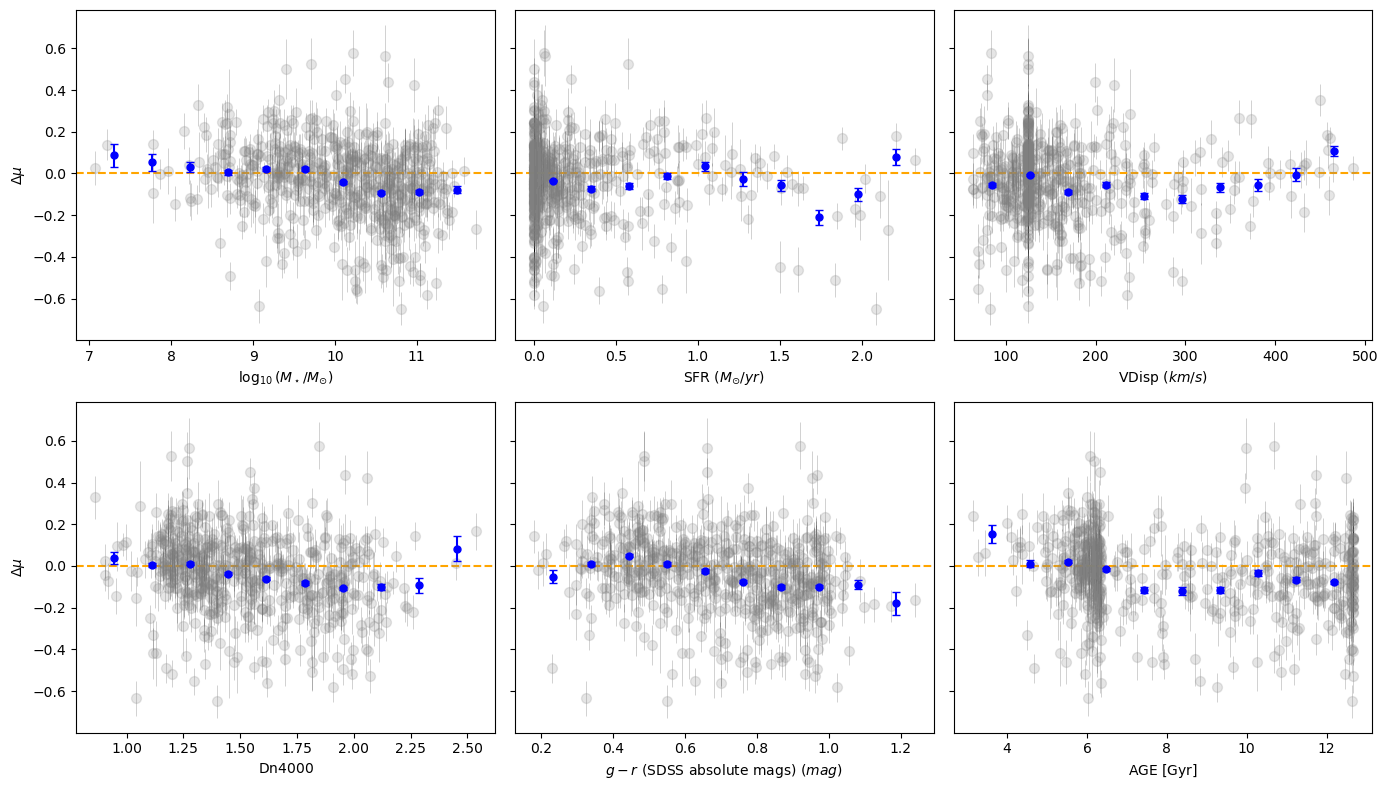

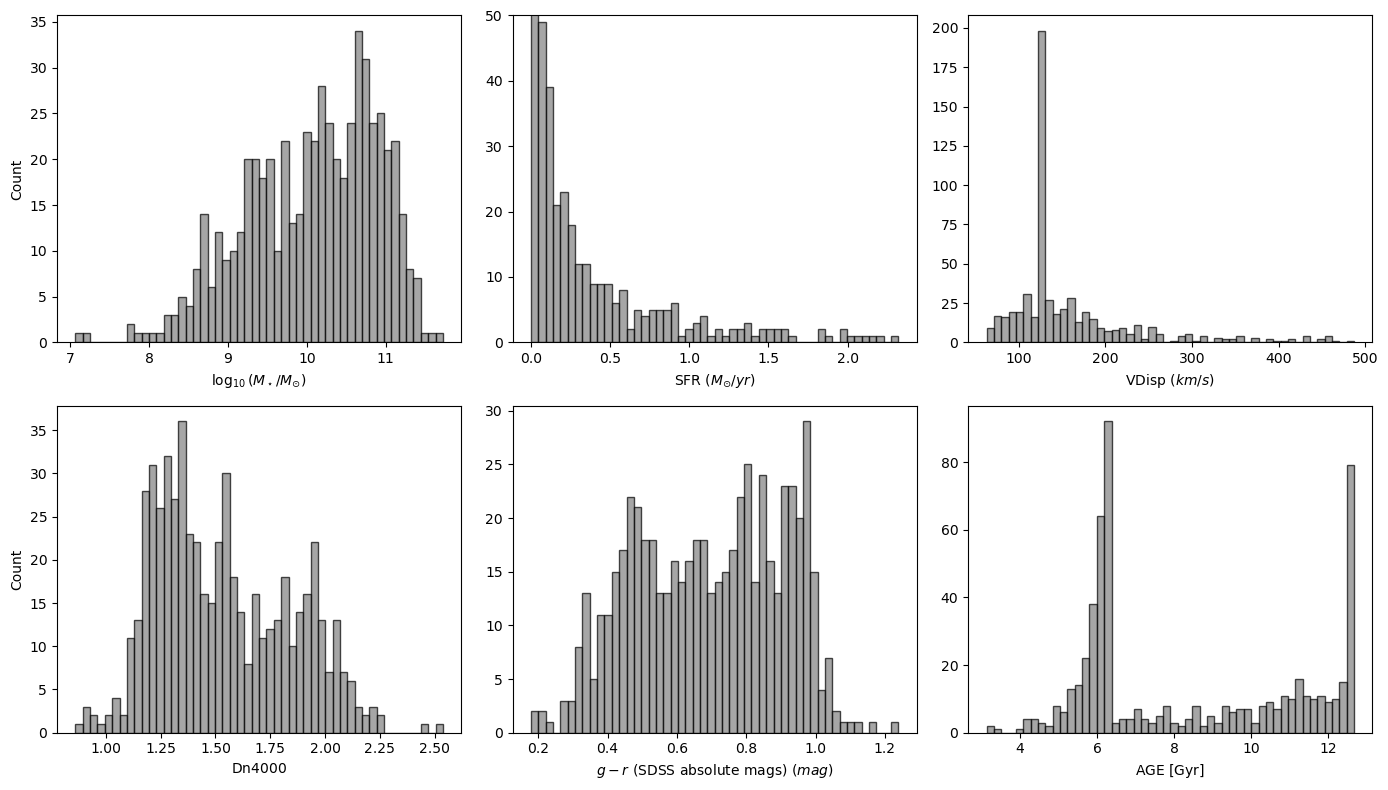

In [3]:
df = pd.read_csv("ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_with_residuals_with_musig.csv")

# -----------------------------------------------------
# DATA FILTER - Paper lccoverage_flag and fitquality_flag
# -------------------------------------------------------
print(len(df), "SNe before paper-based quality cuts.")
df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]
print(len(df), "SNe after paper-based quality cuts.")

# --------------------------------------
# Create g - r host-galaxy color
# --------------------------------------
df["SDSS_g_minus_r"] = df["ABSMAG01_SDSS_G"] - df["ABSMAG01_SDSS_R"]

# Read the Error Collumn for the distance modulus measurements.
yerr_all = df["sigma_mu_meas"]

nbins = 10

# Helper funciton that plots the scatter and error bars. 
# ax - matplotlib axis where the plots will be drawn. 
# mask - the mask that selects which rows to use. 
# xcol - name of the df collumn to put on the x axis. Note residuals are always on the y-axis here.

def scatter_with_errors(ax, mask, xcol, nbins=None):
    # Raw values
    x = df.loc[mask, xcol].values
    y = df.loc[mask, "residual_centered"].values
    yerr = yerr_all.loc[mask].values

    # --- sigma clipping in y (vertical axis) ---
    clipped = sigma_clip(y, sigma=3, maxiters=1)
    mask_clip = ~clipped.mask  # True = keep point

    # apply clipping to x, y, yerr
    x = x[mask_clip]
    y = y[mask_clip]
    yerr = yerr[mask_clip]


    # --- scatter cloud ---
    ax.scatter(x, y, **point_kwargs)

    # --- individual error bars ---
    # Important to note that the way that this function works we will be drawing 
    # an error bar line from y - yerr to y + yerr. Where y_err = sigma_i
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="none",
        ecolor="black",
        elinewidth=0.5,
        alpha=0.25,
        zorder=2,
    )

    # horizontal reference
    ax.axhline(0, linestyle="--", color="orange")

    # --- BINNING WITH ERROR PROPAGATION ---
    # NOTE: we set the number of bins here. 

    # binned_statistic is a function tha takes (x, values, ststics, bins, range)
    # x - an array of positions along the x-axis.
    # values - the vaules on which the statistics are computed inside each bin. 
    # NOTE: here we want to just count the number of points in each bin on the 
    # horizontal axis of our plots. Therefore we parse "x" as both the argument and the 
    # value and simply choose "count" as our statistics option. 
    # bin_edges is an array of bin boundaries
    # binnumber - the index for which data point each bin belongs in.
    # This is done mostly becaue the data on the horizontal axis is not ranked so
    # we have to give it an identifier when we do our bin statistics later on. 
    # Bin centers are just calcualted as the middle points between one bin edge and another.
    
    _, bin_edges, binnumber = binned_statistic(x, x, statistic="count", bins=10) 
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Creating arrays for ht residuals. 
    binned_y = []
    binned_yerr = []

    # Just a fancy way of saying "for each bin"
    # We end up appending the data and error means into
    # an array. 
    for i in range(1, len(bin_edges)):
        in_bin = binnumber == i

        # We end up finding data and errro associated
        # with the number of bin that we are in. 
        y_bin = y[in_bin]
        err_bin = yerr[in_bin]
    
        # inverse-variance weights
        w = 1.0 / (err_bin**2)
    
        # weighted mean
        y_mean = np.sum(w * y_bin) / np.sum(w)
    
        # propagated error on the mean
        err_mean = 1.0 / np.sqrt(np.sum(w))
    
        binned_y.append(y_mean)
        binned_yerr.append(err_mean)

    ax.errorbar(
        bin_centers,
        binned_y,
        yerr=binned_yerr,
        fmt="o",
        color="blue",
        markersize=5,
        capsize=3,
        zorder = 5 # Keeps the data looking on top
    )

# **************************************
# --------------------------------------
# Set up 2x3 grid - RESIDUALS + ERRORS + BINS w/t ERRORS
# --------------------------------------
# **************************************


fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharey=True)
axes = axes.flatten()

point_kwargs = dict(alpha=0.2, s=50, color="grey", zorder=3)   

# --------------------------------------
# 1) LOGMSTAR
# --------------------------------------
ax = axes[0]

# finite values mask (same as before)
mask_logm = np.isfinite(df["LOGMSTAR"])
print(np.sum(mask_logm), "SNe after LOGMSTAR cut.")

# Use helper function with binning ON
scatter_with_errors(ax, mask_logm, "LOGMSTAR", nbins)

# Axis labels
ax.set_xlabel(r"$\log_{10}(M_\star / M_{\odot})$")
ax.set_ylabel(r"$\Delta \mu$")

# --------------------------------------
# 2) SFR (cut SFR > 2.5)
# --------------------------------------
ax = axes[1]

# Exclude SFR > 2.5
mask_sfr = (df["SFR"] <= 2.5)
print(np.sum(mask_sfr), "SNe after SFR cut.")

scatter_with_errors(ax, mask_sfr, "SFR", nbins=nbins)

ax.set_xlabel(r"${\rm SFR}\ (M_{\odot}/yr)$")

# --------------------------------------
# 3) VDISP
# --------------------------------------
ax = axes[2]

mask_vdisp = np.isfinite(df["VDISP"])
print(np.sum(mask_vdisp), "SNe after VDISP cut.")

scatter_with_errors(ax, mask_vdisp, "VDISP", nbins=nbins)

ax.set_xlabel(r"${\rm VDisp }\  (km/s) $")


# --------------------------------------
# 4) DN4000  (cut DN4000 < 0.5)
# --------------------------------------
ax = axes[3]

# keep only finite values AND DN4000 >= 0.5
mask_dn4000 = df["DN4000"] >= 0.5
print(np.sum(mask_dn4000), "SNe after DN4000 cut.")

scatter_with_errors(ax, mask_dn4000, "DN4000", nbins=nbins)

ax.set_xlabel(r"${\rm Dn4000}$")
ax.set_ylabel(r"$\Delta \mu$")


# --------------------------------------
# 5) SDSS g - r
# --------------------------------------
ax = axes[4]

mask_sdssq = np.isfinite(df["SDSS_g_minus_r"])
print(np.sum(mask_sdssq), "SNe after SDSS g-r cut.")

scatter_with_errors(ax, mask_sdssq, "SDSS_g_minus_r", nbins=nbins)

ax.set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}\ (mag)$")


# --------------------------------------
# 6) AGE  (cut AGE < 2)
# --------------------------------------
ax = axes[5]

# keep only finite AGE and AGE >= 2
mask_age = df["AGE"] >= 2

print(np.sum(mask_age), "SNe after AGE cut.")

scatter_with_errors(ax, mask_age, "AGE", nbins=nbins)

ax.set_xlabel(r"${\rm AGE}\ [{\rm Gyr}]$")

# --------------------------------------
# Global cosmetics
# --------------------------------------

fig.tight_layout()
plt.show()

# **************************************
# --------------------------------------
# Set up 2x3 grid - HISTOGRAMS
# --------------------------------------
# **************************************

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

# Global Histogram Parameters which are included here 
# in order to keep the histogram the same. 
hist_kwargs = dict(bins=50, alpha=0.7, edgecolor="black", color="grey")

# --------------------------------------
# 1) LOGMSTAR
# --------------------------------------
# mask_logm is already defined when the weighed bins were being plotted
# (in the above code)
# mask_logm is an array of true and false values where "True" means
# the data points are to be kept. 

# when we write df.loc[mask_logm, "LOGMSTAR"], we are selecting
# only the LOGMSTAR values where the mask is True.

# its important to match the masks we defined previously so that we end up. 

axes[0].hist(df.loc[mask_logm, "LOGMSTAR"].values, **hist_kwargs)
axes[0].set_xlabel(r"$\log_{10}(M_\star / M_{\odot})$")
axes[0].set_ylabel("Count")

# --------------------------------------
# 2) SFR (same cuts as above)
# --------------------------------------
axes[1].hist(df.loc[mask_sfr, "SFR"].values, **hist_kwargs)
axes[1].set_ylim(0, 50)
axes[1].set_xlabel(r"${\rm SFR}\ (M_{\odot}/yr)$")

# --------------------------------------
# 3) VDISP
# --------------------------------------
axes[2].hist(df.loc[mask_vdisp, "VDISP"].values, **hist_kwargs)
axes[2].set_xlabel(r"${\rm VDisp }\  (km/s) $")

# --------------------------------------
# 4) DN4000  
# --------------------------------------
axes[3].hist(df.loc[mask_dn4000, "DN4000"].values, **hist_kwargs)
axes[3].set_xlabel(r"${\rm Dn4000}$")
axes[3].set_ylabel("Count")

# --------------------------------------
# 5) SDSS g - r
# --------------------------------------
axes[4].hist(df.loc[mask_sdssq, "SDSS_g_minus_r"].values, **hist_kwargs)
axes[4].set_xlabel(r"$g - r~{\rm (SDSS ~ absolute ~ mags)}\ (mag)$")

# --------------------------------------
# 6) AGE  (cut AGE < 2)
# --------------------------------------
axes[5].hist(df.loc[mask_age, "AGE"].values, **hist_kwargs)
axes[5].set_xlabel(r"${\rm AGE}\ [{\rm Gyr}]$")

# --------------------------------------
# Global cosmetics
# --------------------------------------

fig.tight_layout()
plt.show()


# Plot of the Residuals Histogram After Quality Cuts and Sigma Clipping #

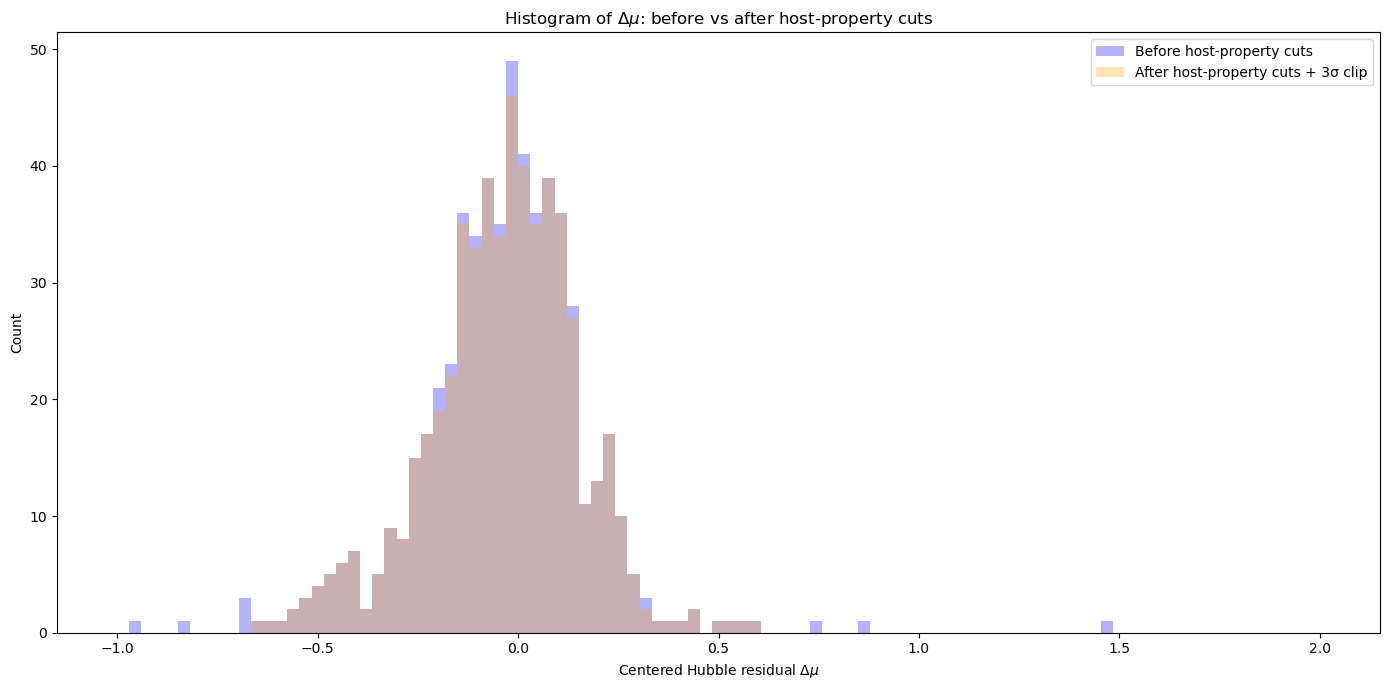

Before host-property cuts:            579
After host-property cuts:             566
After host cuts + 3σ clipping:        558


In [5]:


# --------------------------------------
# One complete mask that combines all 
# the other masks out there. 
# --------------------------------------
mask_all = mask_logm & mask_sfr & mask_vdisp & mask_dn4000 & mask_sdssq & mask_age

# --------------------------------------
# Residuals BEFORE host-property cuts and sigma clipping
# --------------------------------------
resid_before = df["residual_centered"]

# --------------------------------------
# Apply all host-property cuts
# --------------------------------------
df_hostcut = df.loc[mask_all].copy()

# --------------------------------------
# Sigma clip ONCE on what's left (host-cut sample)
# --------------------------------------
resid_hostcut = df_hostcut["residual_centered"].to_numpy()

# resid_clip is a masked array which contains boolean values of the 
# points that were kept or rejected after sigma clipping.
# True = rejected point (i.e. clipped values), False = kept point.
resid_clip = sigma_clip(
    resid_hostcut,
    sigma=3.0,
    maxiters=1,
    cenfunc="median",
    stdfunc="std"
)

# Note how sigma_mask is defined as the opposite of resid_clip.maks
# that is because the False values in resid_clip.mask correspond to the
# points that were kept after sigma clipping.
sigma_clip_mask = ~resid_clip.mask # 

# Array for plotting (kept points only)
resid_after_clip = resid_hostcut[sigma_clip_mask]
# --------------------------------------
# Plot overlaid histograms
# --------------------------------------
bins = np.linspace(-1, 2, 100)
plt.figure(figsize=(14, 7))

# Note we can plot the "before" histogram directly from the dataframe
# because we already applied the paper-based quality cuts earlier on.
# The commands for these cuts is: 
# df = df[(df["lccoverage_flag"] == 1) & (df["fitquality_flag"] == 1)]

plt.hist(
    resid_before,
    color="blue",
    bins = bins,
    alpha=0.3,
    label="Before host-property cuts"
)

plt.hist(
    resid_after_clip,
    color="orange",
    bins = bins,
    alpha=0.3,
    label="After host-property cuts + 3σ clip"
)

plt.xlabel(r"Centered Hubble residual $\Delta \mu$")
plt.ylabel("Count")
plt.title(r"Histogram of $\Delta \mu$: before vs after host-property cuts")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Before host-property cuts:            {len(resid_before)}")
print(f"After host-property cuts:             {len(df_hostcut)}")
print(f"After host cuts + 3σ clipping:        {len(resid_hostcut[sigma_clip_mask])}")

# --------------------------------------
# Save final science sample
# --------------------------------------
#  
df_hostcut_sigclip = df_hostcut.loc[sigma_clip_mask].copy()

df_hostcut_sigclip.to_csv(
    "ZTF_DESI_data/ZTF_snia_DESI_fastspec_hostprops_papercuts_hostcuts_sigclip3.csv",
    index=False
)